Frozen Lake

In [ ]:
import numpy as np
import gymnasium as gym
from IPython.display import display, HTML, clear_output
import time

# FrozenLake environment map
env_map = {
    0: 'S', 1: 'F', 2: 'F', 3: 'F',
    4: 'F', 5: 'H', 6: 'F', 7: 'H',
    8: 'F', 9: 'F', 10: 'F', 11: 'H',
    12: 'H', 13: 'F', 14: 'F', 15: 'G'
}
NROWS, NCOLS = 4, 4 # number of rows and number of columns

def render_frozen_lake_html(state, visited_states, sleep=0.4, persist=False):
    """
    Renders a full 4x4 matrix where:
      - Letters stay S/F/H/G
      - Current agent cell is highlighted strongly
      - Visited cells are softly highlighted
    If persist=False, it animates (clears each frame).
    If persist=True, it stacks frames (useful if you want a full log of every step).
    """
    cells = []
    for i in range(NROWS * NCOLS):
        letter = env_map[i]
        # styles: change only background/border, not the letter
        if i == state:
            # agent cell: highlighted strongly
            style = "background:#90EE90; border:3px solid #2E7D32; font-weight:600;"
        elif i in visited_states:
            # visited cells: softly highlighted
            style = "background:#FFF59D; border:1px solid #BDB76B;"
        else:
            # neutral cells
            style = "background:#F7F7F7; border:1px solid #DDDDDD;"
        # optional: give special subtle tints to Start/Goal (keeps letters)
        if letter == 'S' and i != state:
            style = style.replace("#F7F7F7", "#E3F2FD")
        if letter == 'G' and i != state:
            style = style.replace("#F7F7F7", "#E8F5E9")

        # Create HTML for each table cell (<td>)
        cells.append(f'<td style="width:40px;height:40px;text-align:center;'
                     f'vertical-align:middle;font-family:monospace;font-size:16px;{style}">{letter}</td>')

    rows = []
    # Create HTML for each table row (<tr>)
    for r in range(NROWS):
        row_html = "<tr>" + "".join(cells[r*NCOLS:(r+1)*NCOLS]) + "</tr>"
        rows.append(row_html)

    # Assemble the full HTML table (<table>)
    table = (
        "<div style='margin:6px 0'>"
        "<table style='border-collapse:collapse;'>"
        f"{''.join(rows)}"
        "</table>"
        "</div>"
    )

    if not persist:
        # Clear previous output for animation
        clear_output(wait=True)
    # Display the current frame
    display(HTML(table))
    # Pause for a short duration
    time.sleep(sleep)

# Initialize the FrozenLake environment
env = gym.make("FrozenLake-v1")

# Define hyperparameters for Q-learning
alpha = 0.1  # Learning rate (how much to update Q-values)
gamma = 0.99  # Discount factor (importance of future rewards)
epsilon = 1.0  # Initial exploration probability (chance of taking a random action)
epsilon_decay_rate = 0.0001 # Epsilon decay rate (how much epsilon decreases each episode)
rng = np.random.default_rng() # Random number generator for exploration

# Assuming a qtable is expected, initialize it to zeros
# Q-table stores Q-values for each state-action pair
qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Create training loop
num_episodes = 10000 # Number of training episodes

print("Starting training...")
for episode in range(num_episodes):
    # Reset the environment for a new episode
    obs = env.reset()
    # Extract the state from the observation
    state = obs[0] if isinstance(obs, tuple) else obs
    done = False
    truncated = False

    # Loop until the episode is done or truncated
    while not done and not truncated:
        # Implement the epsilon-greedy policy
        # Choose a random action (explore) with probability epsilon
        if rng.random() < epsilon:
            action = env.action_space.sample()  # Explore action space
        # Choose the action with the highest Q-value (exploit)
        else:
            action = int(np.argmax(qtable[state, :]))  # Exploit learned values

        # Take a step in the environment with the chosen action
        step_result = env.step(action)
        # Handle different return formats from gym.step()
        if len(step_result) == 5:
            new_state, reward, done, truncated, info = step_result
        else:
            new_state, reward, done, info = step_result
            truncated = False

        # Ensure new_state is an integer
        new_state = int(new_state)

        # Implement the Q-table update rule (Bellman equation)
        # Q(s, a) = Q(s, a) + alpha * (reward + gamma * max(Q(s', a')) - Q(s, a))
        qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

        # Update the current state
        state = new_state

    # Decay the epsilon value after each episode
    # Decrease epsilon to reduce exploration over time, but keep a minimum for continued exploration
    epsilon = max(0.01, epsilon - epsilon_decay_rate) # ensure epsilon doesn't go below a minimum

print("Training finished.")


# -------------------------
# Inference/visualization run (greedy w.r.t qtable)
# -------------------------
# Reset the environment to start a new episode for inference.
obs = env.reset()
# Extract the state from the observation
state = obs[0] if isinstance(obs, tuple) else obs

# Initialize a set to keep track of visited states for visualization.
visited_states = set()

# Set a maximum number of steps for the inference episode.
max_steps = 100

# If you want to keep every frame (a full log), set PERSIST_FRAMES=True
# Set to False for animation
PERSIST_FRAMES = False

print("Starting Inference Episode: 1")

# Start a loop for the inference episode, continuing until the episode is done or truncated, or the maximum number of steps is reached.
for step in range(max_steps):
    # Inside the loop, render the current state of the environment using the provided render_frozen_lake_html function, passing the current state and visited states.
    # This will animate the agent's movement
    render_frozen_lake_html(state, visited_states, sleep=0.35, persist=PERSIST_FRAMES)

    # Add the current state to the set of visited states.
    visited_states.add(state)

    # Choose the action with the highest Q-value from the learned Q-table for the current state (greedy policy).
    # No exploration during inference
    action = int(np.argmax(qtable[state, :]))

    # Take a step in the environment using the chosen action.
    step_result = env.step(action)
    # Handle different return formats from gym.step()
    if len(step_result) == 5:
        new_state, reward, done, truncated, info = step_result
    else:
        new_state, reward, done, info = step_result
        truncated = False

    # Update the current state based on the result of the step.
    state = int(new_state)

    # If the episode is done or truncated, render the final state, print a message indicating whether the agent reached the goal or fell into a hole, and print the number of steps taken.
    # Break out of the loop if the episode is done or truncated.
    if done or truncated:
        # Render the final state
        render_frozen_lake_html(state, visited_states, sleep=0.35, persist=PERSIST_FRAMES)
        # Print outcome based on the final state
        if state == 15:
            print("The agent has reached the goal!")
        elif state in [5, 7, 11, 12]:
            print("The agent fell into a hole!")
        # Print the number of steps taken
        print("Number of steps:", step + 1)
        break

# Close the environment after the inference episode is finished.
env.close()

S,F,F,F
F,H,F,H
F,F,F,H
H,F,F,G


The agent has reached the goal!
Number of steps: 26


This notebook utilizes several key libraries to train an agent to navigate the Frozen Lake environment. We use gymnasium to provide the Frozen Lake environment. Numpy is used for numerical operations, particularly for handling the Q-table and implementing the epsilon-greedy policy. The visualization of the agent's movement within the environment is achieved using IPython.display to render HTML. HTML is used to create a custom, grid-based visual representation of the environment that can be updated at each step to show the agent's position and highlight visited states, offering a more intuitive understanding than the default text-based rendering. Time is used to control the animation speed.

The core of the solution is the Q-learning algorithm, which helps an agent learn the optimal action-selection policy by iteratively updating Q-values. The algorithm works by learning an action-value function, stored in a Q-table, that estimates the expected future reward for taking a specific action in a given state. During training, the agent explores the environment using an epsilon-greedy policy, which balances exploration (trying random actions) and exploitation (choosing the action with the highest estimated value). The Q-table is iteratively updated based on the rewards received and the estimated future rewards of the next state, using the Bellman equation. The Bellman essentially states that the optimal Q-value for a given state-action pair is the immediate reward received from taking that action, plus the discounted maximum expected future reward from the next state. Over time, this process allows the agent to learn an optimal policy for navigating the Frozen Lake and reaching the goal while avoiding holes.

Second Project: Crypto Trading Using Reinforcement Learning

In [2]:
%pip install stable-baselines3 gymnasium pandas matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
from stable_baselines3 import PPO

# Assuming 'historical_data' is a pandas DataFrame with historical prices
# Create a dummy historical_data for demonstration purposes if it doesn't exist
try:
    historical_data
except NameError:
    print("Creating dummy historical_data for demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='D'))
    crypto_names = [f'crypto_{i}' for i in range(25)]
    data = np.random.rand(100, 25) * 1000 # Simulate price data
    historical_data = pd.DataFrame(data, index=dates, columns=crypto_names)


# Instantiate the environment
env = CryptoTradingEnv(historical_data=historical_data)

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=0)

print("PPO agent created.")

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


PPO agent created.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
import gymnasium as gym
import numpy as np
import pandas as pd

class CryptoTradingEnv(gym.Env):
    """Custom Gymnasium environment for cryptocurrency trading."""

    def __init__(self, historical_data, initial_balance=100000, transaction_fee=0.001):
        super().__init__()
        self.historical_data = historical_data
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.n_cryptos = historical_data.shape[1] # Assuming each column is a crypto price series

        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.n_cryptos) # Number of units of each crypto held

        # Define observation space: current prices, current balance, current holdings
        # The shape should be n_cryptos (prices) + 1 (balance) + n_cryptos (holdings)
        obs_low = np.array([0.0] * (self.n_cryptos + 1 + self.n_cryptos)) # min price is 0, min balance 0, min holdings 0
        obs_high = np.array([np.inf] * (self.n_cryptos + 1 + self.n_cryptos)) # max is infinity
        self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)


        # Define action space: for each crypto, buy, sell, or hold (represented by a value between -1 and 1)
        # -1: sell, 0: hold, 1: buy
        # We'll use a continuous action space for simplicity, where the value represents the fraction of current balance to trade (for buy) or fraction of holdings to trade (for sell)
        self.action_space = gym.spaces.Box(low=np.array([-1.0] * self.n_cryptos), high=np.array([1.0] * self.n_cryptos), dtype=np.float32)


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.n_cryptos)
        observation = self._get_observation()
        info = {} # Optional: any additional info to return
        return observation, info

    def step(self, action):
        # action is an array of size n_cryptos, with values between -1 and 1
        # -1 means sell, 1 means buy, 0 means hold
        # The magnitude indicates the fraction of balance (for buy) or holdings (for sell)

        portfolio_value_before = self._get_portfolio_value()

        for i in range(self.n_cryptos):
            current_price = self._get_current_prices()[i]
            trade_action = action[i]

            if trade_action > 0: # Buy
                amount_to_spend = self.balance * trade_action
                if amount_to_spend > 0 and current_price > 0:
                    num_units_to_buy = amount_to_spend / current_price
                    transaction_cost = num_units_to_buy * current_price * self.transaction_fee
                    if self.balance >= amount_to_spend + transaction_cost:
                        self.balance -= amount_to_spend + transaction_cost
                        self.holdings[i] += num_units_to_buy

            elif trade_action < 0: # Sell
                fraction_to_sell = abs(trade_action)
                num_units_to_sell = self.holdings[i] * fraction_to_sell
                if num_units_to_sell > 0 and current_price > 0:
                    transaction_cost = num_units_to_sell * current_price * self.transaction_fee
                    self.balance += num_units_to_sell * current_price - transaction_cost
                    self.holdings[i] -= num_units_to_sell


        self.current_step += 1

        done = self.current_step >= len(self.historical_data) - 1 # Episode ends when data runs out

        portfolio_value_after = self._get_portfolio_value()
        reward = portfolio_value_after - portfolio_value_before # Reward is the change in portfolio value

        observation = self._get_observation()
        info = {'portfolio_value': portfolio_value_after}

        truncated = False # No truncation in this environment

        return observation, reward, done, truncated, info

    def _get_observation(self):
        # Returns the current observation for the agent
        # This includes the current prices, current balance, and current holdings
        current_prices = self._get_current_prices()
        observation = np.concatenate([current_prices, [self.balance], self.holdings])
        return observation


    def _get_current_prices(self):
        # Returns the current prices of all cryptocurrencies
        if self.current_step < len(self.historical_data):
            return self.historical_data.iloc[self.current_step].values
        else:
            return self.historical_data.iloc[-1].values # Return last prices if at the end


    def _get_portfolio_value(self):
        # Calculates the total value of the portfolio (balance + value of holdings)
        current_prices = self._get_current_prices()
        holdings_value = np.sum(self.holdings * current_prices)
        return self.balance + holdings_value

In [8]:
from stable_baselines3 import PPO
# CryptoTradingEnv is defined in the previous cell

# Instantiate the corrected environment
env = CryptoTradingEnv(historical_data=historical_data)

# Instantiate the agent again
model = PPO("MlpPolicy", env, verbose=0)

# Train the agent
model.learn(total_timesteps=10000)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdim

Model training complete.


In [9]:
# Create a new instance of the environment for evaluation (using the same historical data)
eval_env = CryptoTradingEnv(historical_data=historical_data)

# Reset the environment
obs, info = eval_env.reset()

# Initialize list to store portfolio values, getting the initial value from the environment
portfolio_values = [eval_env._get_portfolio_value()]

# Iterate through the environment
done = False
truncated = False
while not done and not truncated:
    # Get action from the trained model
    action, _states = model.predict(obs, deterministic=True)

    # Take a step in the environment
    obs, reward, done, truncated, info = eval_env.step(action)

    # Append portfolio value from the info dictionary returned by step
    portfolio_values.append(info['portfolio_value'])

# Store the list of portfolio values
# This is already done by appending to the portfolio_values list in the loop.

print("Evaluation complete. Portfolio values stored.")

Evaluation complete. Portfolio values stored.


/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


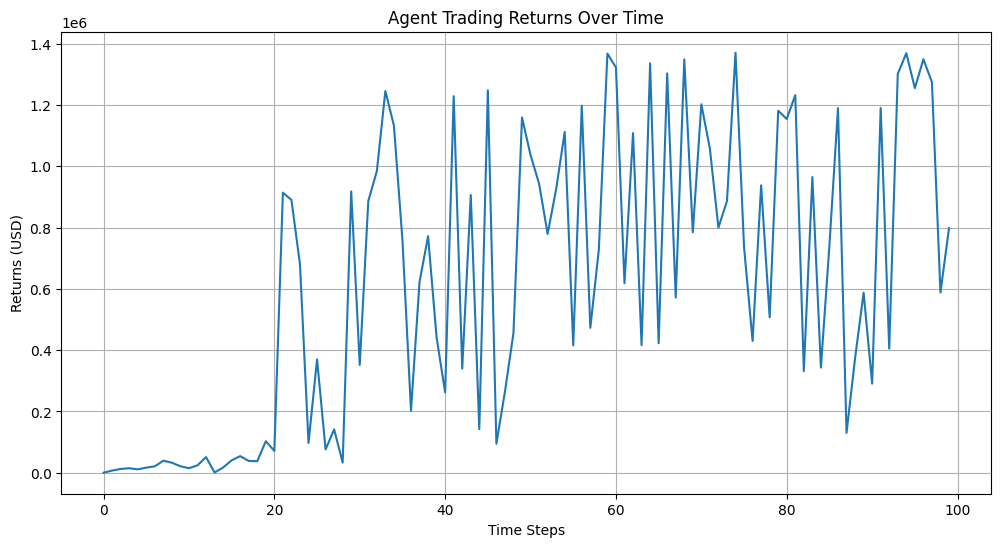

In [10]:
import matplotlib.pyplot as plt

# Calculate the returns in dollars
initial_balance = 100000  # Assuming the initial balance was 100000 as set in the environment
returns_in_dollars = [value - initial_balance for value in portfolio_values]

plt.figure(figsize=(12, 6))
plt.plot(returns_in_dollars)
plt.xlabel('Time Steps')
plt.ylabel('Returns (USD)')
plt.title('Agent Trading Returns Over Time')
plt.grid(True)
plt.show()

This project implements a cryptocurrency trading agent using reinforcement learning. A custom trading environment, CryptoTradingEnv, was created using the Gymnasium library to simulate trading on historical price data for 25 different cryptocurrencies. The environment manages the agent's balance and holdings, incorporating transaction fees and calculating portfolio value at each step. The agent's actions are represented as a continuous space, allowing it to decide what fraction of its balance to use for buying or what fraction of its holdings to sell for each cryptocurrency. The observation space provides the agent with current prices, its current balance, and its current holdings.

The reinforcement learning agent uses the Proximal Policy Optimization (PPO) algorithm from the stable-baselines3 library. The PPO agent was trained within the custom CryptoTradingEnv using historical data. The goal of the training is to maximize the agent's cumulative reward, which is defined as the change in portfolio value at each time step. After training, the agent's performance was evaluated on the same historical data, and the returns in USD over time were visualized to show the profitability of the learned trading strategy. As shown in the graph, the agent's portfolio value increased over time, indicating that the learned trading strategy was profitable on this historical data. Due to time constraints for the assignment submission, historical data was used for training and evaluation as opposed to real-time data.